In [1]:
import importlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns
from sklearn import metrics
import torch

from models import ff, persistent, rnn
from utils import data_utils, data_loader, model_utils, shape_utils

importlib.reload(data_utils)
importlib.reload(data_loader)
importlib.reload(shape_utils)

%matplotlib inline

RUN_FOLDER = "../results/small/"
NETWORK = "kcm/"
FOLD_MODEL = 4
device = torch.device("cpu")
NUM_WORKERS = 4
HIDDEN_SIZE = 32
BATCH_SIZE = 64

In [2]:
kcm_inputs = data_utils.load_all_inputs(RUN_FOLDER, "kcm/")
atb_inputs = data_utils.load_all_inputs(RUN_FOLDER, "atb/")

# Make dataloaders
kcm_dataloader = data_loader.make_generic_dataloader(
    kcm_inputs['test_data'],
    kcm_inputs['config'],
    BATCH_SIZE,
    data_loader.basic_collate,
    NUM_WORKERS
)
atb_dataloader = data_loader.make_generic_dataloader(
    atb_inputs['test_data'],
    atb_inputs['config'],
    BATCH_SIZE,
    data_loader.basic_collate,
    NUM_WORKERS
)
kcm_dataloader_seq_mto = data_loader.make_generic_dataloader(
    kcm_inputs['test_data'],
    kcm_inputs['config'],
    BATCH_SIZE,
    data_loader.sequential_mto_collate,
    NUM_WORKERS
)
atb_dataloader_seq_mto = data_loader.make_generic_dataloader(
    atb_inputs['test_data'],
    atb_inputs['config'],
    BATCH_SIZE,
    data_loader.sequential_mto_collate,
    NUM_WORKERS
)
kcm_dataloader_seq = data_loader.make_generic_dataloader(
    kcm_inputs['test_data'],
    kcm_inputs['config'],
    BATCH_SIZE,
    data_loader.sequential_collate,
    NUM_WORKERS
)
atb_dataloader_seq = data_loader.make_generic_dataloader(
    atb_inputs['test_data'],
    atb_inputs['config'],
    BATCH_SIZE,
    data_loader.sequential_collate,
    NUM_WORKERS
)
_, kcm_mask_seq = data_utils.get_seq_info(kcm_dataloader_seq)
_, atb_mask_seq = data_utils.get_seq_info(atb_dataloader_seq)

# Define embedded variables for nn models
kcm_embed_dict = {
    'timeID': {
        'vocab_size': 1440,
        'embed_dims': 24
    },
    'weekID': {
        'vocab_size': 7,
        'embed_dims': 4
    }
}
# Define embedded variables for nn models
atb_embed_dict = {
    'timeID': {
        'vocab_size': 1440,
        'embed_dims': 24
    },
    'weekID': {
        'vocab_size': 7,
        'embed_dims': 4
    }
}

In [7]:
# Load trained models
kcm_model = ff.FF(
    "FF",
    11,
    HIDDEN_SIZE,
    kcm_embed_dict,
    device
)
kcm_model.load_state_dict(torch.load(f"{RUN_FOLDER}kcm/models/FF_{FOLD_MODEL}.pt"))
# print(kcm_model.eval())
print(sum(p.numel() for p in kcm_model.parameters() if p.requires_grad))

kcm_model_seq = rnn.GRU_RNN_MTO(
    "GRU_RNN_MTO",
    8,
    1,
    HIDDEN_SIZE,
    BATCH_SIZE,
    kcm_embed_dict,
    device
)
kcm_model_seq.load_state_dict(torch.load(f"{RUN_FOLDER}kcm/models/GRU_RNN_MTO_{FOLD_MODEL}.pt"))
# print(kcm_model_seq.eval())
print(sum(p.numel() for p in kcm_model_seq.parameters() if p.requires_grad))

atb_model = ff.FF(
    "FF",
    11,
    HIDDEN_SIZE,
    atb_embed_dict,
    device
)
atb_model.load_state_dict(torch.load(f"{RUN_FOLDER}atb/models/FF_{FOLD_MODEL}.pt"))
# print(atb_model.eval())
print(sum(p.numel() for p in atb_model.parameters() if p.requires_grad))

atb_model_seq = rnn.GRU_RNN_MTO(
    "GRU_RNN_MTO",
    8,
    1,
    HIDDEN_SIZE,
    BATCH_SIZE,
    atb_embed_dict,
    device
)
atb_model_seq.load_state_dict(torch.load(f"{RUN_FOLDER}atb/models/GRU_RNN_MTO_{FOLD_MODEL}.pt"))
# print(atb_model_seq.eval())
print(sum(p.numel() for p in atb_model_seq.parameters() if p.requires_grad))

36957
38681
36957
38681


In [5]:
pytorch_total_params = sum(p.numel() for p in atb_model.parameters() if p.requires_grad)
pytorch_total_params

36957

In [4]:
# Load baseline models
kcm_model_baseline = data_utils.load_pkl(f"{RUN_FOLDER}kcm/models/AVG_{FOLD_MODEL}.pkl")
kcm_model_baseline_seq = data_utils.load_pkl(f"{RUN_FOLDER}kcm/models/PER_TIM_{FOLD_MODEL}.pkl")
atb_model_baseline = data_utils.load_pkl(f"{RUN_FOLDER}atb/models/AVG_{FOLD_MODEL}.pkl")
atb_model_baseline_seq = data_utils.load_pkl(f"{RUN_FOLDER}atb/models/PER_TIM_{FOLD_MODEL}.pkl")
all_results = []

In [5]:
# Test KCM on KCM
train_network = "KCM"
test_network = "KCM"
labels, preds = kcm_model_baseline.predict(kcm_dataloader)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{kcm_model_baseline.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(kcm_model, kcm_dataloader)
labels = data_utils.de_normalize(labels, kcm_inputs['config']['time_mean'], kcm_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, kcm_inputs['config']['time_mean'], kcm_inputs['config']['time_std'])
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{kcm_model.model_name}"
}))
labels, preds = kcm_model_baseline_seq.predict(kcm_dataloader_seq)
preds = data_utils.aggregate_tts(preds, kcm_mask_seq)
labels = data_utils.aggregate_tts(labels, kcm_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{kcm_model_baseline_seq.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(kcm_model_seq, kcm_dataloader_seq_mto, sequential_flag=False)
labels = data_utils.de_normalize(labels, kcm_inputs['config']['time_mean'], kcm_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, kcm_inputs['config']['time_mean'], kcm_inputs['config']['time_std'])
# preds = data_utils.aggregate_tts(preds, kcm_mask_seq)
# labels = data_utils.aggregate_tts(labels, kcm_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{kcm_model_seq.model_name}"
}))

In [6]:
# Test KCM on ATB
train_network = "KCM"
test_network = "ATB"
labels, preds = kcm_model_baseline.predict(atb_dataloader)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{kcm_model_baseline.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(kcm_model, atb_dataloader)
labels = data_utils.de_normalize(labels, kcm_inputs['config']['time_mean'], kcm_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, kcm_inputs['config']['time_mean'], kcm_inputs['config']['time_std'])
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{kcm_model.model_name}"
}))
labels, preds = kcm_model_baseline_seq.predict(atb_dataloader_seq)
preds = data_utils.aggregate_tts(preds, atb_mask_seq)
labels = data_utils.aggregate_tts(labels, atb_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{kcm_model_baseline_seq.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(atb_model_seq, atb_dataloader_seq_mto, sequential_flag=False)
labels = data_utils.de_normalize(labels, kcm_inputs['config']['time_mean'], kcm_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, kcm_inputs['config']['time_mean'], kcm_inputs['config']['time_std'])
# preds = data_utils.aggregate_tts(preds, atb_mask_seq)
# labels = data_utils.aggregate_tts(labels, atb_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{kcm_model_seq.model_name}"
}))

In [7]:
# Test ATB on ATB
train_network = "ATB"
test_network = "ATB"
labels, preds = atb_model_baseline.predict(atb_dataloader)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_baseline.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(atb_model, atb_dataloader)
labels = data_utils.de_normalize(labels, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model.model_name}"
}))
labels, preds = atb_model_baseline_seq.predict(atb_dataloader_seq)
preds = data_utils.aggregate_tts(preds, atb_mask_seq)
labels = data_utils.aggregate_tts(labels, atb_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_baseline_seq.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(atb_model_seq, atb_dataloader_seq_mto, sequential_flag=False)
labels = data_utils.de_normalize(labels, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
# preds = data_utils.aggregate_tts(preds, atb_mask_seq)
# labels = data_utils.aggregate_tts(labels, atb_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_seq.model_name}"
}))

In [8]:
# Test ATB on KCM
train_network = "ATB"
test_network = "KCM"
labels, preds = atb_model_baseline.predict(kcm_dataloader)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_baseline.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(atb_model, kcm_dataloader)
labels = data_utils.de_normalize(labels, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model.model_name}"
}))
labels, preds = atb_model_baseline_seq.predict(kcm_dataloader_seq)
preds = data_utils.aggregate_tts(preds, kcm_mask_seq)
labels = data_utils.aggregate_tts(labels, kcm_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_baseline_seq.model_name}"
}))
labels, preds, avg_loss = model_utils.predict(atb_model_seq, kcm_dataloader_seq_mto, sequential_flag=False)
labels = data_utils.de_normalize(labels, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
preds = data_utils.de_normalize(preds, atb_inputs['config']['time_mean'], atb_inputs['config']['time_std'])
# preds = data_utils.aggregate_tts(preds, kcm_mask_seq)
# labels = data_utils.aggregate_tts(labels, kcm_mask_seq)
all_results.append(pd.DataFrame({
    "Labels": labels,
    "Preds": preds,
    "Train Network": train_network,
    "Test Network": test_network,
    "Model": f"{atb_model_seq.model_name}"
}))

In [9]:
gen_df = pd.concat(all_results)
gen_df['Residuals'] = abs(gen_df['Labels'] - gen_df['Preds'])
gen_df

,Labels,Preds,Train Network,Test Network,Model,Residuals
0,923.000000,1481.801683,KCM,KCM,AVG,558.801683
1,973.000000,1352.625397,KCM,KCM,AVG,379.625397
2,1110.000000,1454.525250,KCM,KCM,AVG,344.525250
3,976.000000,1074.482958,KCM,KCM,AVG,98.482958
4,968.000000,1329.070525,KCM,KCM,AVG,361.070525
...,...,...,...,...,...,...
65429,690.691589,719.201416,ATB,KCM,GRU_RNN_MTO,28.509827
65430,498.463623,435.800293,ATB,KCM,GRU_RNN_MTO,62.663330
65431,559.579590,475.625580,ATB,KCM,GRU_RNN_MTO,83.954010
65432,478.613983,616.373962,ATB,KCM,GRU_RNN_MTO,137.759979


In [10]:
metric_results = gen_df.groupby(['Model','Train Network','Test Network'], as_index=False).apply(lambda x: np.round(np.sqrt(metrics.mean_squared_error(x.Labels, x.Preds)), 2))
metric_results.columns = ["Model","Train Network","Test Network","Metric"]
metric_results['Train-Test-Model'] = metric_results['Train Network']+"_"+metric_results['Test Network']+"_"+metric_results['Model']
metric_results = metric_results.sort_values('Train-Test-Model')
metric_results

,Model,Train Network,Test Network,Metric,Train-Test-Model
0,AVG,ATB,ATB,768.32,ATB_ATB_AVG
4,FF,ATB,ATB,221.51,ATB_ATB_FF
8,GRU_RNN_MTO,ATB,ATB,201.84,ATB_ATB_GRU_RNN_MTO
12,PER_TIM,ATB,ATB,467.60,ATB_ATB_PER_TIM
1,AVG,ATB,KCM,318.79,ATB_KCM_AVG
5,FF,ATB,KCM,383.41,ATB_KCM_FF
9,GRU_RNN_MTO,ATB,KCM,273.81,ATB_KCM_GRU_RNN_MTO
13,PER_TIM,ATB,KCM,341.28,ATB_KCM_PER_TIM
2,AVG,KCM,ATB,666.34,KCM_ATB_AVG
6,FF,KCM,ATB,653.38,KCM_ATB_FF


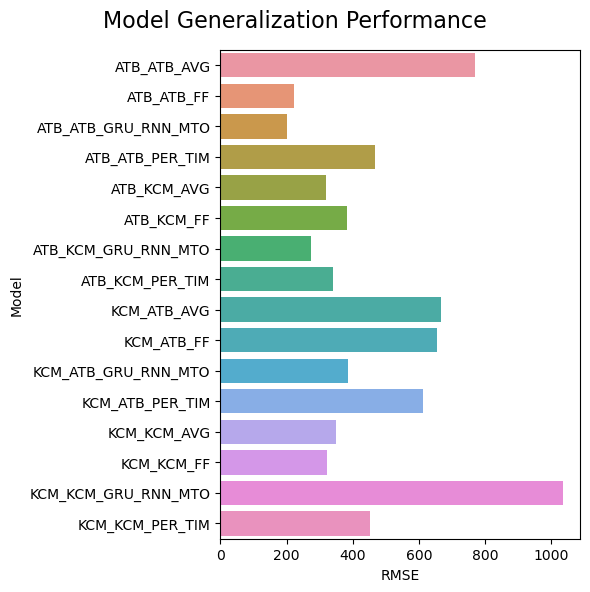

In [11]:
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(6)
sns.barplot(metric_results, x="Metric", y="Train-Test-Model")
axes.set_ylabel("Model")
axes.set_xlabel("RMSE")
fig.suptitle('Model Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_generalization.png", dpi=1800, bbox_inches='tight')